In [1]:
#Importing libraries
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, Embedding
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


import tensorflow as tf
import pandas as pd
import tokenize, glob
import os, re, requests, tarfile, shutil, json, glob # For file manipualation only.


In [2]:
%tensorflow_version X.X
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
# Experiment with tokenize library to see its use
with tokenize.open('Data/p00002/Python/s005515634.py') as f:
    tokens = tokenize.generate_tokens(f.readline)
    for token in tokens:
        print(token)

TokenInfo(type=1 (NAME), string='while', start=(1, 0), end=(1, 5), line='while True:\n')
TokenInfo(type=1 (NAME), string='True', start=(1, 6), end=(1, 10), line='while True:\n')
TokenInfo(type=54 (OP), string=':', start=(1, 10), end=(1, 11), line='while True:\n')
TokenInfo(type=4 (NEWLINE), string='\n', start=(1, 11), end=(1, 12), line='while True:\n')
TokenInfo(type=5 (INDENT), string='    ', start=(2, 0), end=(2, 4), line='    try:\n')
TokenInfo(type=1 (NAME), string='try', start=(2, 4), end=(2, 7), line='    try:\n')
TokenInfo(type=54 (OP), string=':', start=(2, 7), end=(2, 8), line='    try:\n')
TokenInfo(type=4 (NEWLINE), string='\n', start=(2, 8), end=(2, 9), line='    try:\n')
TokenInfo(type=5 (INDENT), string='        ', start=(3, 0), end=(3, 8), line='        a, b = map(int, input().split())\n')
TokenInfo(type=1 (NAME), string='a', start=(3, 8), end=(3, 9), line='        a, b = map(int, input().split())\n')
TokenInfo(type=54 (OP), string=',', start=(3, 9), end=(3, 10), line=' 

In [4]:
all_files = glob.glob('data/*/Python/*.py')
print(len(all_files))
np.savetxt('all_py_files.txt', X = all_files, delimiter=',', comments='', fmt='%s')

1600


In [5]:
all_files_mini = glob.glob('data/*/Python/*.py')
np.savetxt('all_py_files.txt', X = all_files_mini, delimiter=',', comments='', fmt='%s')
len(all_files_mini)

1600

In [6]:
def tokenize_and_save(dir_name):
  tokenizerD = Tokenizer(
    num_words=10000,
    filters='',
    lower=False, split=' ', char_level=False, oov_token="<UNK>",
    document_count=0
  )
  
  # Assumes a file with all_py_files.txt name
  file_index = 1
  # with open(dir_name + 'all_py_files.txt') as dir_f:
  #   for py_file in dir_f.readlines():
  for py_file in all_files:
    file_index = file_index + 1
    with tokenize.open(py_file.strip()) as f:
      try:
        tokens = [tok.string for tok in tokenize.generate_tokens(f.readline)]
        tokenizerD.fit_on_texts(tokens)
      except:
        pass 

      if file_index % 2000 == 0:
        print(str(file_index) + " python files tokenized with #tokens: " + str(len(tokenizerD.word_index)))
        tokenizer_json = tokenizerD.to_json()
        with open(dir_name + 'tokenizer.json', 'w') as f:
          json.dump(tokenizer_json, f)

  # Save final version
  tokenizer_json = tokenizerD.to_json()
  with open(dir_name + 'tokenizer.json', 'w') as f:
    json.dump(tokenizer_json, f)

  print('Total tokenizer vocabulary {}'.format(len(tokenizerD.word_index)))


tokenize_and_save('IBM project')

Total tokenizer vocabulary 2091


In [7]:
#Load tokens into 'tokenizer' file. Total tokens created is 213461

path_full = "tokenizer.json"
# path_full = "drive/MyDrive/code_completion_data/samples/tokenizer.json"

with open(path_full) as f:
  json_string = json.load(f)

tokenizer = keras.preprocessing.text.tokenizer_from_json(
    json_string
)
len(tokenizer.word_index)

1048

In [8]:
with open('tokenizer.json') as f:
  json_string = json.load(f)

tokenizer_mini = keras.preprocessing.text.tokenizer_from_json(
    json_string
)

len(tokenizer_mini.word_index)

1048

In [9]:
# files is a list of python files to generate vector on
def vectorize_and_save(files):
  # Load tokenizer
  with open("tokenizer.json") as f:
    json_string = json.load(f)

  tokenizer = keras.preprocessing.text.tokenizer_from_json(
      json_string
  )
  
  seq_length = 10
  header_str = "X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y"
  file_index = 1
  py_file_index = 1
  dataX = []
  n_patterns = 0
  max_rows_in_each_file = 10000000
  for py_file in files:
    with tokenize.open(py_file.strip()) as f:
      try:
        py_file_index = py_file_index + 1
        py_tokens = [tok.string for tok in tokenize.generate_tokens(f.readline)]
        # Now convert the python tokens into an array of tokens from our Corpus tokenizer

        words_tokens = [0]*seq_length + [tokenizer.word_index[w] if w in tokenizer.word_index else tokenizer.word_index['<UNK>'] for w in py_tokens] # Get token id if exists else use <UNK>

        for j in range(len(words_tokens) - seq_length):
          dataX.append(words_tokens[j:j+seq_length+1])

        # Save to file if data reaches max count or if its the last row.
        if len(dataX) >= max_rows_in_each_file:
          file_name = 'dataxy_10_1_{}.csv'.format(file_index)
          np.savetxt(fname = file_name, 
                    X = dataX, 
                    delimiter=',', 
                    comments='',
                    fmt='%d',
                    header=header_str)
          n_patterns = n_patterns + len(dataX)
          dataX = []
          file_index = file_index + 1
          print("Saved to file " + file_name)

        if py_file_index % 2000 == 0:
          print("Processed files {} with dataset size {}".format(py_file_index, n_patterns + len(dataX)))
      except:
        pass 

  # Save once more for left items unsaved
  file_name = 'dataxy_10_1_{}.csv'.format(file_index)
  np.savetxt(fname = file_name, 
            X = dataX, 
            delimiter=',', 
            comments='',
            fmt='%d',
            header=header_str)
  n_patterns = n_patterns + len(dataX)
  
  print("Saved to file " + file_name)

  print ("Total Patterns: ", n_patterns)

In [14]:
py_files = glob.iglob('data/*/Python/*.py')
vectorize_and_save(py_files)

Saved to file dataxy_10_1_1.csv
Total Patterns:  130369


In [15]:
# Now generate on entire dataset full
py_files = glob.iglob('data/*/Python/*.py')
vectorize_and_save(py_files)

Saved to file dataxy_10_1_1.csv
Total Patterns:  130369


In [16]:
dataxy = pd.read_csv('dataxy_10_1_1.csv', header = 0)
display(dataxy)
dataX = dataxy.iloc[:, 0:10].values
dataY = dataxy.iloc[:, 10].values

print(dataX)
print(dataY)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0,0,0,0,0,0,0,0,0,0,27
1,0,0,0,0,0,0,0,0,0,27,5
2,0,0,0,0,0,0,0,0,27,5,45
3,0,0,0,0,0,0,0,27,5,45,3
4,0,0,0,0,0,0,27,5,45,3,1
...,...,...,...,...,...,...,...,...,...,...,...
130364,5,52,3,105,4,2,18,3,50,3,105
130365,52,3,105,4,2,18,3,50,3,105,4
130366,3,105,4,2,18,3,50,3,105,4,4
130367,105,4,2,18,3,50,3,105,4,4,1


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  27]
 [  0   0   0 ...   0  27   5]
 ...
 [  3 105   4 ...   3 105   4]
 [105   4   2 ... 105   4   4]
 [  4   2  18 ...   4   4   1]]
[27  5 45 ...  4  1  1]


In [17]:
tokenizer.word_index

{'<UNK>': 1,
 '\n': 2,
 '(': 3,
 ')': 4,
 '=': 5,
 ':': 6,
 ',': 7,
 '.': 8,
 '1': 9,
 '_': 10,
 'a': 11,
 '"': 12,
 '[': 13,
 ']': 14,
 'x': 15,
 '0': 16,
 'i': 17,
 'print': 18,
 'input': 19,
 '*': 20,
 'y': 21,
 'n': 22,
 'int': 23,
 '2': 24,
 "'": 25,
 'if': 26,
 's': 27,
 'in': 28,
 'for': 29,
 '-': 30,
 'b': 31,
 'w': 32,
 'h': 33,
 'ans': 34,
 '+': 35,
 'split': 36,
 '/': 37,
 'r': 38,
 'else': 39,
 'range': 40,
 'max': 41,
 'map': 42,
 '#': 43,
 '9': 44,
 'list': 45,
 '%': 46,
 '\t': 47,
 'import': 48,
 'math': 49,
 'len': 50,
 'l': 51,
 'str': 52,
 'pi': 53,
 'def': 54,
 'append': 55,
 'and': 56,
 'return': 57,
 'elif': 58,
 'sys': 59,
 '>': 60,
 'c': 61,
 '3': 62,
 '5': 63,
 '{': 64,
 '}': 65,
 'f': 66,
 '!': 67,
 'm': 68,
 'gcd': 69,
 'while': 70,
 '<': 71,
 '6': 72,
 'min': 73,
 'float': 74,
 'num': 75,
 'main': 76,
 'join': 77,
 "''": 78,
 '8': 79,
 'stdin': 80,
 'd': 81,
 'format': 82,
 't': 83,
 'true': 84,
 '?': 85,
 'or': 86,
 'from': 87,
 'replace': 88,
 '4': 89,
 're

In [18]:
print(dataX.shape)
print(dataY.shape)
print(len(np.unique(dataY)))
# Lets build model
vocab_size_to_predict = len(tokenizer.word_index)+1

model = Sequential()
model.add(Embedding(input_dim=vocab_size_to_predict, output_dim=32, mask_zero=True))
model.add(LSTM(256, input_shape=(dataX.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(units = vocab_size_to_predict, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

(130369, 10)
(130369,)
623


2022-11-11 21:36:55.510751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
## 9. Train and save the best model on Data here
#filepath = "LSTM_model.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
 #                            save_best_only=True, mode='min')
#history = model.fit(dataX, dataY, epochs=20, batch_size=64, callbacks=[checkpoint])

In [81]:
from sklearn.model_selection import train_test_split
X = dataX
y = dataY
dataX, X_test, dataY, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [83]:
print(X)
print(y)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 37]
 [ 0  0  0 ...  0 37  5]
 ...
 [ 3 60  4 ...  3 60  4]
 [60  4  2 ... 60  4  4]
 [ 4  2 17 ...  4  4  1]]
[37  5 31 ...  4  1  1]


In [20]:
with open('tokenizer.json') as f:
  json_string = json.load(f)

tokenizer= keras.preprocessing.text.tokenizer_from_json(
    json_string
)

print(len(tokenizer.word_index))
tokenizer.word_index

1048


{'<UNK>': 1,
 '\n': 2,
 '(': 3,
 ')': 4,
 '=': 5,
 ':': 6,
 ',': 7,
 '.': 8,
 '1': 9,
 '_': 10,
 'a': 11,
 '"': 12,
 '[': 13,
 ']': 14,
 'x': 15,
 '0': 16,
 'i': 17,
 'print': 18,
 'input': 19,
 '*': 20,
 'y': 21,
 'n': 22,
 'int': 23,
 '2': 24,
 "'": 25,
 'if': 26,
 's': 27,
 'in': 28,
 'for': 29,
 '-': 30,
 'b': 31,
 'w': 32,
 'h': 33,
 'ans': 34,
 '+': 35,
 'split': 36,
 '/': 37,
 'r': 38,
 'else': 39,
 'range': 40,
 'max': 41,
 'map': 42,
 '#': 43,
 '9': 44,
 'list': 45,
 '%': 46,
 '\t': 47,
 'import': 48,
 'math': 49,
 'len': 50,
 'l': 51,
 'str': 52,
 'pi': 53,
 'def': 54,
 'append': 55,
 'and': 56,
 'return': 57,
 'elif': 58,
 'sys': 59,
 '>': 60,
 'c': 61,
 '3': 62,
 '5': 63,
 '{': 64,
 '}': 65,
 'f': 66,
 '!': 67,
 'm': 68,
 'gcd': 69,
 'while': 70,
 '<': 71,
 '6': 72,
 'min': 73,
 'float': 74,
 'num': 75,
 'main': 76,
 'join': 77,
 "''": 78,
 '8': 79,
 'stdin': 80,
 'd': 81,
 'format': 82,
 't': 83,
 'true': 84,
 '?': 85,
 'or': 86,
 'from': 87,
 'replace': 88,
 '4': 89,
 're

In [21]:
tokenizer.word_docs

{'s': 1299,
 '=': 9746,
 '[': 2443,
 ']': 2443,
 '\n': 15645,
 'a': 2465,
 'int': 1683,
 '(': 12350,
 'input': 2055,
 ')': 12346,
 'if': 1506,
 '0': 2238,
 ':': 4840,
 '.': 3315,
 'append': 360,
 'elif': 343,
 '1': 3004,
 'else': 768,
 'len': 429,
 '>': 309,
 'pop': 100,
 'for': 1222,
 'l': 413,
 'in': 1259,
 'print': 2160,
 'list': 581,
 'map': 679,
 'str': 388,
 ',': 3835,
 'split': 880,
 'ans': 1011,
 'i': 2213,
 '"': 2448,
 'b': 1183,
 'del': 30,
 '-': 1206,
 'join': 210,
 'range': 720,
 "'": 1585,
 "'b'": 105,
 '!': 275,
 'remove': 18,
 "''": 210,
 'is': 28,
 '+': 923,
 'and': 358,
 'while': 267,
 '#': 678,
 'bが存在する間実行': 1,
 'index': 54,
 '最初のbのインデックスを取得': 1,
 'bが先頭でないとき': 1,
 'bの': 1,
 '個前とbを消す': 1,
 'bが先頭の時': 1,
 'この区切り文字でリストを連結': 1,
 '*': 1962,
 'q': 28,
 'chr': 3,
 'x': 2298,
 '8': 178,
 'sep': 19,
 'result': 83,
 'raw': 129,
 '_': 2509,
 'out': 38,
 'import': 546,
 'sys': 320,
 'stdin': 173,
 'ni': 3,
 'lambda': 59,
 'ns': 19,
 'na': 10,
 'readline': 97,
 'or': 145,
 'sentenc

In [22]:
# Above can help with large scale traing but lets focus on one file for now
dataxy = pd.read_csv('dataxy_10_1_1.csv', header = 0)
display(dataxy)
dataX = dataxy.iloc[:, 0:10].values
dataY = dataxy.iloc[:, 10].values

print(dataX)
print(dataY)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0,0,0,0,0,0,0,0,0,0,27
1,0,0,0,0,0,0,0,0,0,27,5
2,0,0,0,0,0,0,0,0,27,5,45
3,0,0,0,0,0,0,0,27,5,45,3
4,0,0,0,0,0,0,27,5,45,3,1
...,...,...,...,...,...,...,...,...,...,...,...
130364,5,52,3,105,4,2,18,3,50,3,105
130365,52,3,105,4,2,18,3,50,3,105,4
130366,3,105,4,2,18,3,50,3,105,4,4
130367,105,4,2,18,3,50,3,105,4,4,1


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  27]
 [  0   0   0 ...   0  27   5]
 ...
 [  3 105   4 ...   3 105   4]
 [105   4   2 ... 105   4   4]
 [  4   2  18 ...   4   4   1]]
[27  5 45 ...  4  1  1]


In [27]:
pip install keras-metrics

Note: you may need to restart the kernel to use updated packages.


In [94]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.25, random_state= seed)

In [28]:
import keras_metrics as km

In [23]:
# Rerun with mini dataset
print(dataX.shape)
print(dataY.shape)
print(len(np.unique(dataY)))
# Lets build model
vocab_size_to_predict = len(tokenizer.word_index)+1

model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size_to_predict, output_dim=64, mask_zero=True))
model1.add(LSTM(256, input_shape=(dataX.shape[1], 1)))
model1.add(Dropout(0.01))
model1.add(Dense(1028))
model1.add(Dropout(0.01))
model1.add(Dense(units = vocab_size_to_predict, activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_activations=True)

(130369, 10)
(130369,)
623
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [24]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          67136     
                                                                 
 lstm_1 (LSTM)               (None, 256)               328704    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1028)              264196    
                                                                 
 dropout_2 (Dropout)         (None, 1028)              0         
                                                                 
 dense_2 (Dense)             (None, 1049)              1079421   
                                                                 
Total params: 1,739,457
Trainable params: 1,739,457
No

In [25]:
## 9. Train and save the best model on Mini Data here
filepath = "LSTM_model_mini.hdf5"
checkpoint1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
history1 = model1.fit(dataX, dataY, epochs=40, batch_size=256, callbacks=[checkpoint1])

Epoch 1/40
509/510 [============================>.] - ETA: 0s - loss: 2.7674 - accuracy: 0.3729
Epoch 1: loss improved from inf to 2.76713, saving model to LSTM_model_mini.hdf5
510/510 [==============================] - 45s 83ms/step - loss: 2.7671 - accuracy: 0.3730
Epoch 2/40
509/510 [============================>.] - ETA: 0s - loss: 1.6319 - accuracy: 0.5980
Epoch 2: loss improved from 2.76713 to 1.63198, saving model to LSTM_model_mini.hdf5
510/510 [==============================] - 47s 91ms/step - loss: 1.6320 - accuracy: 0.5979
Epoch 3/40
509/510 [============================>.] - ETA: 0s - loss: 1.3815 - accuracy: 0.6476
Epoch 3: loss improved from 1.63198 to 1.38151, saving model to LSTM_model_mini.hdf5
510/510 [==============================] - 48s 95ms/step - loss: 1.3815 - accuracy: 0.6476
Epoch 4/40
509/510 [============================>.] - ETA: 0s - loss: 1.2420 - accuracy: 0.6758
Epoch 4: loss improved from 1.38151 to 1.24187, saving model to LSTM_model_mini.hdf5
510/510

Epoch 31/40
509/510 [============================>.] - ETA: 0s - loss: 0.3875 - accuracy: 0.8777
Epoch 31: loss improved from 0.39448 to 0.38759, saving model to LSTM_model_mini.hdf5
510/510 [==============================] - 52s 103ms/step - loss: 0.3876 - accuracy: 0.8777
Epoch 32/40
509/510 [============================>.] - ETA: 0s - loss: 0.3809 - accuracy: 0.8801
Epoch 32: loss improved from 0.38759 to 0.38112, saving model to LSTM_model_mini.hdf5
510/510 [==============================] - 54s 105ms/step - loss: 0.3811 - accuracy: 0.8800
Epoch 33/40
509/510 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8809
Epoch 33: loss improved from 0.38112 to 0.37725, saving model to LSTM_model_mini.hdf5
510/510 [==============================] - 54s 105ms/step - loss: 0.3773 - accuracy: 0.8809
Epoch 34/40
509/510 [============================>.] - ETA: 0s - loss: 0.3726 - accuracy: 0.8831
Epoch 34: loss improved from 0.37725 to 0.37257, saving model to LSTM_model_mi

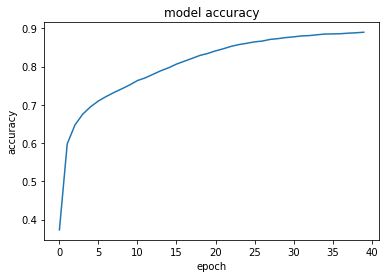

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history1.history['accuracy'])
# plt.plot(history1.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [27]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size_to_predict, output_dim=64, mask_zero=True))
model2.add(SimpleRNN(256, input_shape=(dataX.shape[1], 1)))
model1.add(Dropout(0.01))
model1.add(Dense(1028))
model1.add(Dropout(0.01))
model2.add(Dense(units = vocab_size_to_predict, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [127]:
model2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 64)          29568     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 256)               82176     
                                                                 
 dense_35 (Dense)            (None, 462)               118734    
                                                                 
Total params: 230,478
Trainable params: 230,478
Non-trainable params: 0
_________________________________________________________________


In [128]:
filepath = "RNN_model_mini.hdf5"
checkpoint2 = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
history2 = model2.fit(dataX, dataY, epochs=40, batch_size=256, callbacks=[checkpoint2])

Epoch 1/40
510/510 [==============================] - ETA: 0s - loss: 2.7328 - accuracy: 0.3899
Epoch 1: loss improved from inf to 2.73276, saving model to RNN_model_mini.hdf5
510/510 [==============================] - 10s 19ms/step - loss: 2.7328 - accuracy: 0.3899
Epoch 2/40
509/510 [============================>.] - ETA: 0s - loss: 1.6588 - accuracy: 0.5994
Epoch 2: loss improved from 2.73276 to 1.65874, saving model to RNN_model_mini.hdf5
510/510 [==============================] - 11s 22ms/step - loss: 1.6587 - accuracy: 0.5994
Epoch 3/40
508/510 [============================>.] - ETA: 0s - loss: 1.4197 - accuracy: 0.6442
Epoch 3: loss improved from 1.65874 to 1.42005, saving model to RNN_model_mini.hdf5
510/510 [==============================] - 12s 24ms/step - loss: 1.4200 - accuracy: 0.6441
Epoch 4/40
508/510 [============================>.] - ETA: 0s - loss: 1.3008 - accuracy: 0.6673
Epoch 4: loss improved from 1.42005 to 1.30053, saving model to RNN_model_mini.hdf5
510/510 [==

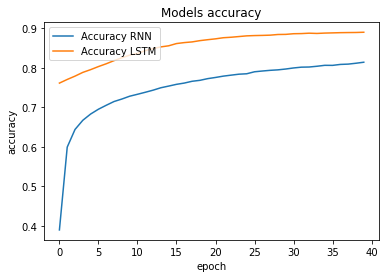

In [130]:
plt.plot(history2.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.title('Models accuracy')
plt.legend(['Accuracy RNN', 'Accuracy LSTM'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [86]:
different = []
for i in range(len(y_p_lstm)):
  if y_p_lstm[i] != y_p_rnn[i]:
    different.append(i)
y_p_lstm[0:10]

NameError: name 'y_p_rnn' is not defined

In [24]:
input = []
output_lstm = []
output_rnn = []

for x in dataX:
  input.append([tokenizer.index_word[i] if i in tokenizer.index_word else '' for i in x])

for y in y_p_lstm:
  output_lstm.append(tokenizer.index_word[y] if y in tokenizer.index_word else '')

for y in y_p_rnn:
  output_rnn.append(tokenizer.index_word[y] if y in tokenizer.index_word else '')

In [28]:
model1 = tf.keras.models.load_model("LSTM_model_mini.hdf5")

In [132]:
model2 = keras.models.load_model("RNN_model_mini.hdf5")

In [29]:
y_p_lstm = model1.predict(dataX)
y_p_lstm = [np.argmax(y_softmax) for y_softmax in y_p_lstm]

4075/4075 [==============================] - 33s 8ms/step


In [133]:
y_p_rnn = model2.predict(dataX)
y_p_rnn = [np.argmax(y_softmax) for y_softmax in y_p_rnn]

4075/4075 [==============================] - 10s 2ms/step


In [140]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print("classfication report:")
print(classification_report(dataY, y_p_rnn))
print("confusion matrix:")
print(confusion_matrix(dataY, y_p_rnn))

classfication report:


/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.77      0.86      0.81     22987
           2       0.84      0.89      0.87     15548
           3       0.96      0.97      0.97     12046
           4       0.95      0.93      0.94     12046
           5       0.91      0.92      0.92      5580
           6       0.94      0.96      0.95      4521
           7       0.86      0.88      0.87      2866
           9       0.87      0.72      0.78      1417
          10       0.60      0.34      0.43      1170
          12       0.83      0.82      0.83      1843
          13       0.91      0.88      0.90      3666
          14       0.75      0.75      0.75      2397
          15       0.93      0.95      0.94      2397
          16       0.91      0.28      0.43        75
          17       0.55      0.75      0.64      2091
          18       0.74      0.87      0.80      2114
          19       0.75      0.84      0.80      1619
          20       0.51    

In [141]:
print("confusion matrix:")
print(confusion_matrix(dataY, y_p_rnn))

confusion matrix:
[[19695   822    84 ...     0     1     0]
 [  903 13884    17 ...     0     0     0]
 [  128    12 11673 ...     0     0     0]
 ...
 [    0     0     0 ...     1     0     0]
 [    1     0     0 ...     0    86     0]
 [    2     0     0 ...     0     0     2]]


In [138]:
MNB_f1 = round(f1_score(dataY, y_p_rnn, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(dataY, y_p_rnn)*100),2)


print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)



Accuracy :  82.2  %
f1_score :  0.816


In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, mean_absolute_error
print("classfication report:")
print(classification_report(dataY, y_p_lstm))

classfication report:
              precision    recall  f1-score   support

           1       0.92      0.90      0.91     21583
           2       0.92      0.93      0.92     15548
           3       0.99      0.99      0.99     12046
           4       0.98      0.96      0.97     12046
           5       0.97      0.93      0.95      5580
           6       0.96      0.99      0.98      4521
           7       0.96      0.95      0.95      3666
           8       0.93      0.94      0.94      2866
           9       0.92      0.90      0.91      1417
          10       0.96      0.36      0.52        75
          11       0.75      0.75      0.75      1703
          13       0.90      0.89      0.90      2397
          14       0.92      0.99      0.96      2397
          15       0.90      0.84      0.87      2075
          16       0.87      0.90      0.89      1381
          17       0.90      0.94      0.92      2114
          18       0.67      0.85      0.75      2091
     

/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
print("confusion matrix:")
print(confusion_matrix(dataY, y_p_lstm))

confusion matrix:
[[19402   361    22 ...     0     0     0]
 [  468 14402     0 ...     0     0     0]
 [   28     5 11881 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     1]]


In [32]:
MNB_f1 = round(f1_score(dataY, y_p_lstm, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(dataY, y_p_lstm)*100),2)


print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

Accuracy :  90.18  %
f1_score :  0.904


In [ ]:
print("Mean Absolute Error:", mean_absolute_error(dataY,y_p_lstm))

In [23]:
y_p_rnn[0:10]

[48, 5, 19, 3, 19, 3, 4, 4, 2, 11]

In [25]:
input[0:10]

[['', '', '', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', '', '', 's'],
 ['', '', '', '', '', '', '', '', 's', '='],
 ['', '', '', '', '', '', '', 's', '=', 'list'],
 ['', '', '', '', '', '', 's', '=', 'list', '('],
 ['', '', '', '', '', 's', '=', 'list', '(', '<UNK>'],
 ['', '', '', '', 's', '=', 'list', '(', '<UNK>', '('],
 ['', '', '', 's', '=', 'list', '(', '<UNK>', '(', ')'],
 ['', '', 's', '=', 'list', '(', '<UNK>', '(', ')', ')'],
 ['', 's', '=', 'list', '(', '<UNK>', '(', ')', ')', '\n']]

In [27]:
output_rnn[0:10]

['import', '=', 'input', '(', 'input', '(', ')', ')', '\n', 'a']

In [26]:
output_lstm[0:10]

['<UNK>', '=', 'input', '(', 'input', '(', ')', ')', '\n', 't']

In [32]:
input[10:20]

[['s', '=', 'list', '(', '<UNK>', '(', ')', ')', '\n', 't'],
 ['=', 'list', '(', '<UNK>', '(', ')', ')', '\n', 't', '='],
 ['list', '(', '<UNK>', '(', ')', ')', '\n', 't', '=', '['],
 ['(', '<UNK>', '(', ')', ')', '\n', 't', '=', '[', ']'],
 ['<UNK>', '(', ')', ')', '\n', 't', '=', '[', ']', '\n'],
 ['(', ')', ')', '\n', 't', '=', '[', ']', '\n', 'for'],
 [')', ')', '\n', 't', '=', '[', ']', '\n', 'for', 'e'],
 [')', '\n', 't', '=', '[', ']', '\n', 'for', 'e', 'in'],
 ['\n', 't', '=', '[', ']', '\n', 'for', 'e', 'in', 's'],
 ['t', '=', '[', ']', '\n', 'for', 'e', 'in', 's', ':']]

In [34]:
output_rnn[10:20]

['=', '[', ']', '\n', 'for', 'i', 'in', 'range', ':', '\n']

In [33]:
output_lstm[10:20]

['=', '[', ']', '\n', 'for', 'i', 'in', 's', ':', '\n']

In [47]:
#2nd Pie chart code for top 6 languages
languages=df.language.value_counts().index
language_values=df.language.value_counts().values
plt.pie(language_values[:6],labels=languages[:6],autopct='%1.2f%%')

NameError: name 'df' is not defined

In [48]:
input[20:30]

[['=', '[', ']', '\n', 'for', 'e', 'in', 's', ':', '\n'],
 ['[', ']', '\n', 'for', 'e', 'in', 's', ':', '\n', '<UNK>'],
 [']', '\n', 'for', 'e', 'in', 's', ':', '\n', '<UNK>', 'if'],
 ['\n', 'for', 'e', 'in', 's', ':', '\n', '<UNK>', 'if', 'e'],
 ['for', 'e', 'in', 's', ':', '\n', '<UNK>', 'if', 'e', 'is'],
 ['e', 'in', 's', ':', '\n', '<UNK>', 'if', 'e', 'is', '<UNK>'],
 ['in', 's', ':', '\n', '<UNK>', 'if', 'e', 'is', '<UNK>', ':'],
 ['s', ':', '\n', '<UNK>', 'if', 'e', 'is', '<UNK>', ':', '\n'],
 [':', '\n', '<UNK>', 'if', 'e', 'is', '<UNK>', ':', '\n', '<UNK>'],
 ['\n', '<UNK>', 'if', 'e', 'is', '<UNK>', ':', '\n', '<UNK>', 'if']]

In [50]:
output_rnn[20:30]

['<UNK>', 'if', 'i', 'is', '<UNK>', ':', '\n', '<UNK>', 'if', 't']

In [49]:
output_lstm[20:30]

['<UNK>', 'if', 'e', 'is', '<UNK>', ':', '\n', '<UNK>', 'if', 't']

In [1]:
print("Mean Absolute Error:", metrics.mean_absolute_error(dataY,y_p_rnn))

NameError: name 'metrics' is not defined

In [ ]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(dataY, y_pred))

In [37]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# define the model
model = RandomForestClassifier()

In [ ]:

# evaluate random forest algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
# define the model
model = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, dataX, dataY, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance


/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/jahnavinp/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [ ]:
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))